# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patiences from a dataset containing patiances with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy


from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [2]:
ls datasets

phys-raw-lead2-HRV-corrected  phys-raw-lead2-HRV-eda


In [3]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [4]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## We check for missing values

In [5]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_SDSD        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

In [6]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

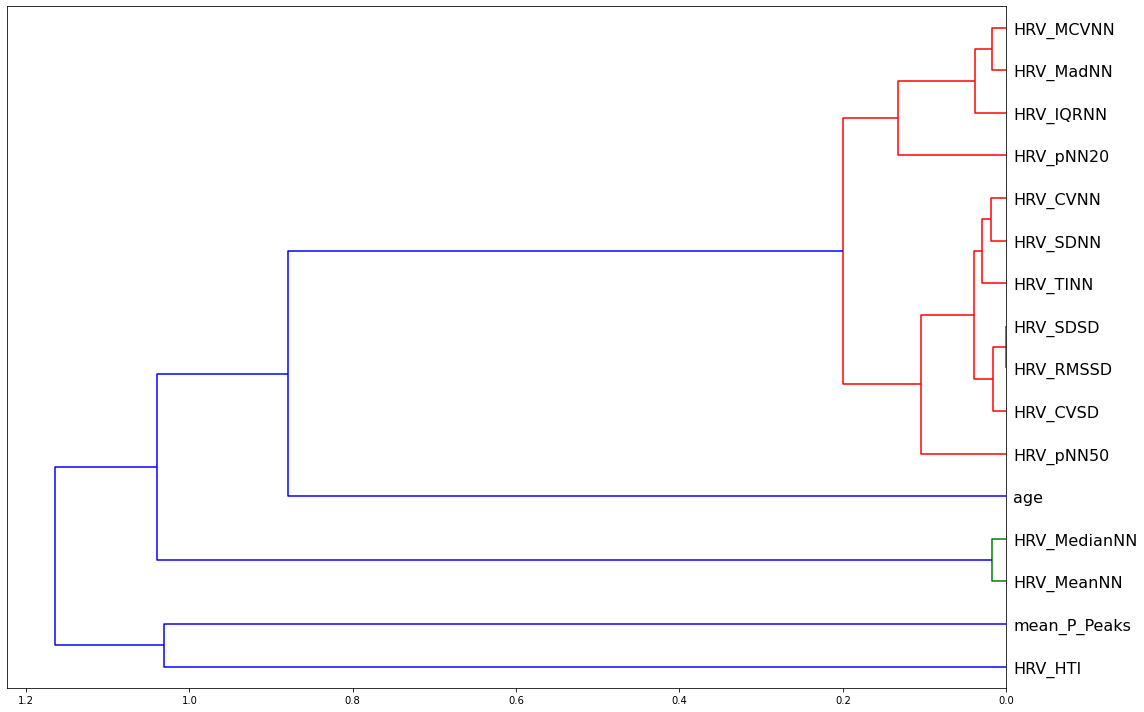

In [7]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.tight_layout()
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [8]:
to_drop = ['HRV_SDSD', 'HRV_MedianNN']
df_raw = df_raw.drop(to_drop, axis=1)

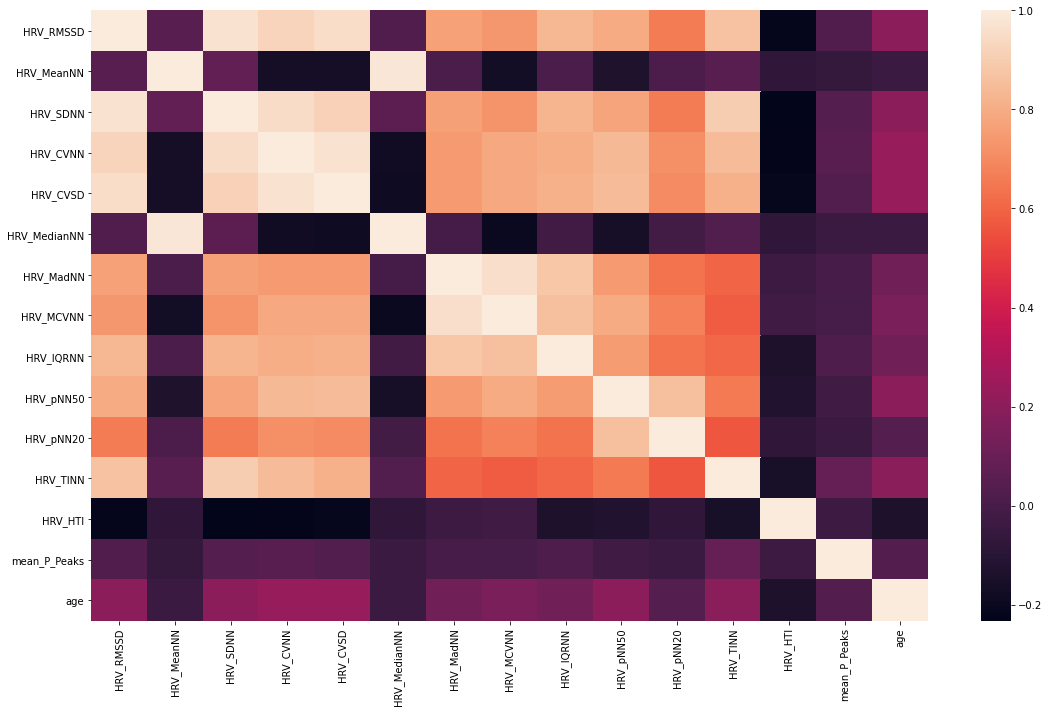

In [9]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())
plt.tight_layout()

### Renaming everything else as "Non-AF" in both sets

In [10]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

In [11]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,Non-AF
count,6873.000000,6873.000000
mean,0.177506,0.822494
std,0.382124,0.382124
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


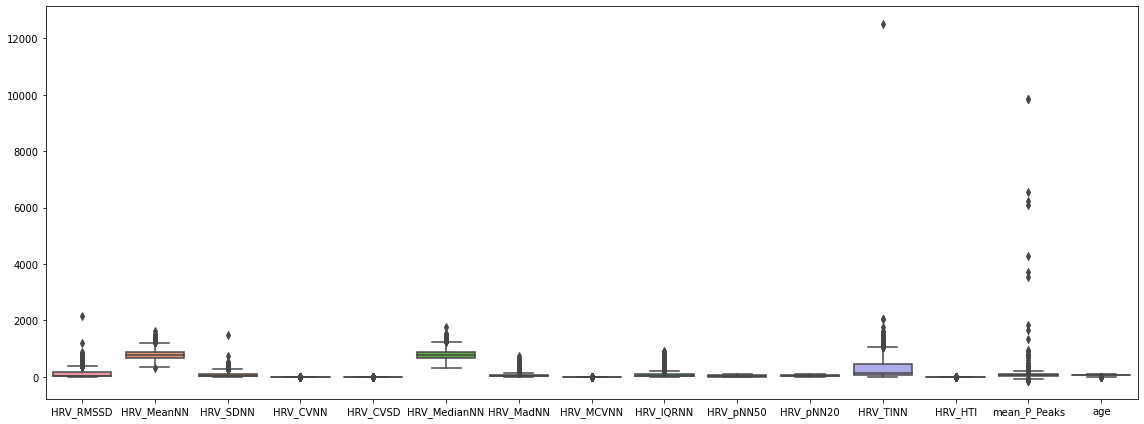

In [12]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df_raw)
plt.tight_layout()
plt.show()

Seems to be an outlier so we'll remove that one from our dataset

In [13]:
#df_raw = df_raw.drop(df_raw.loc[df_raw.HRV_TINN > 12000,'HRV_TINN'].index)
#df_raw = df_raw.drop(df_raw.loc[df_raw.mean_P_Peaks > 1000,'mean_P_Peaks'].index)

In [14]:
df = df_raw.copy()
cols = df_raw.columns
cols = cols.drop('label')
for col in cols:
    df = df[df[col] < df[col].quantile(.99)]
    

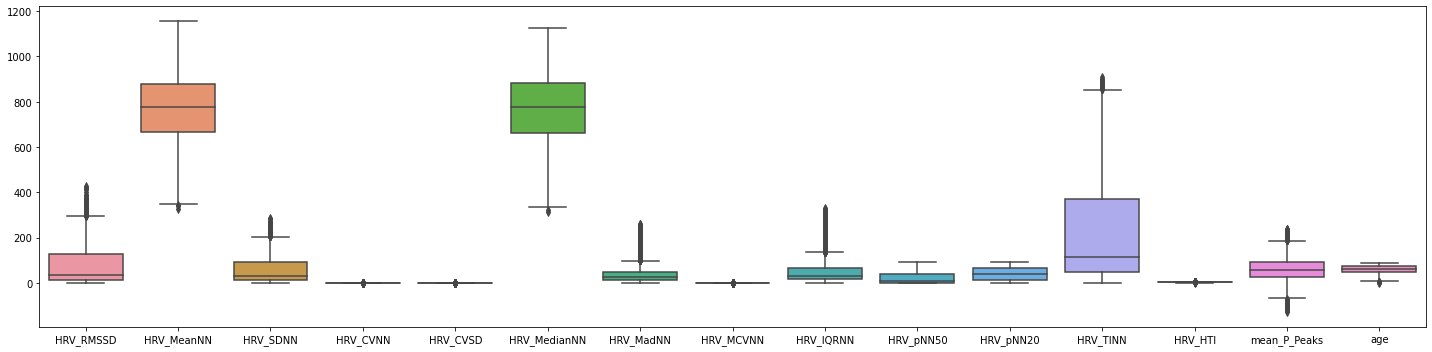

In [15]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df)
plt.tight_layout()
plt.show()

<Figure size 1152x1224 with 0 Axes>

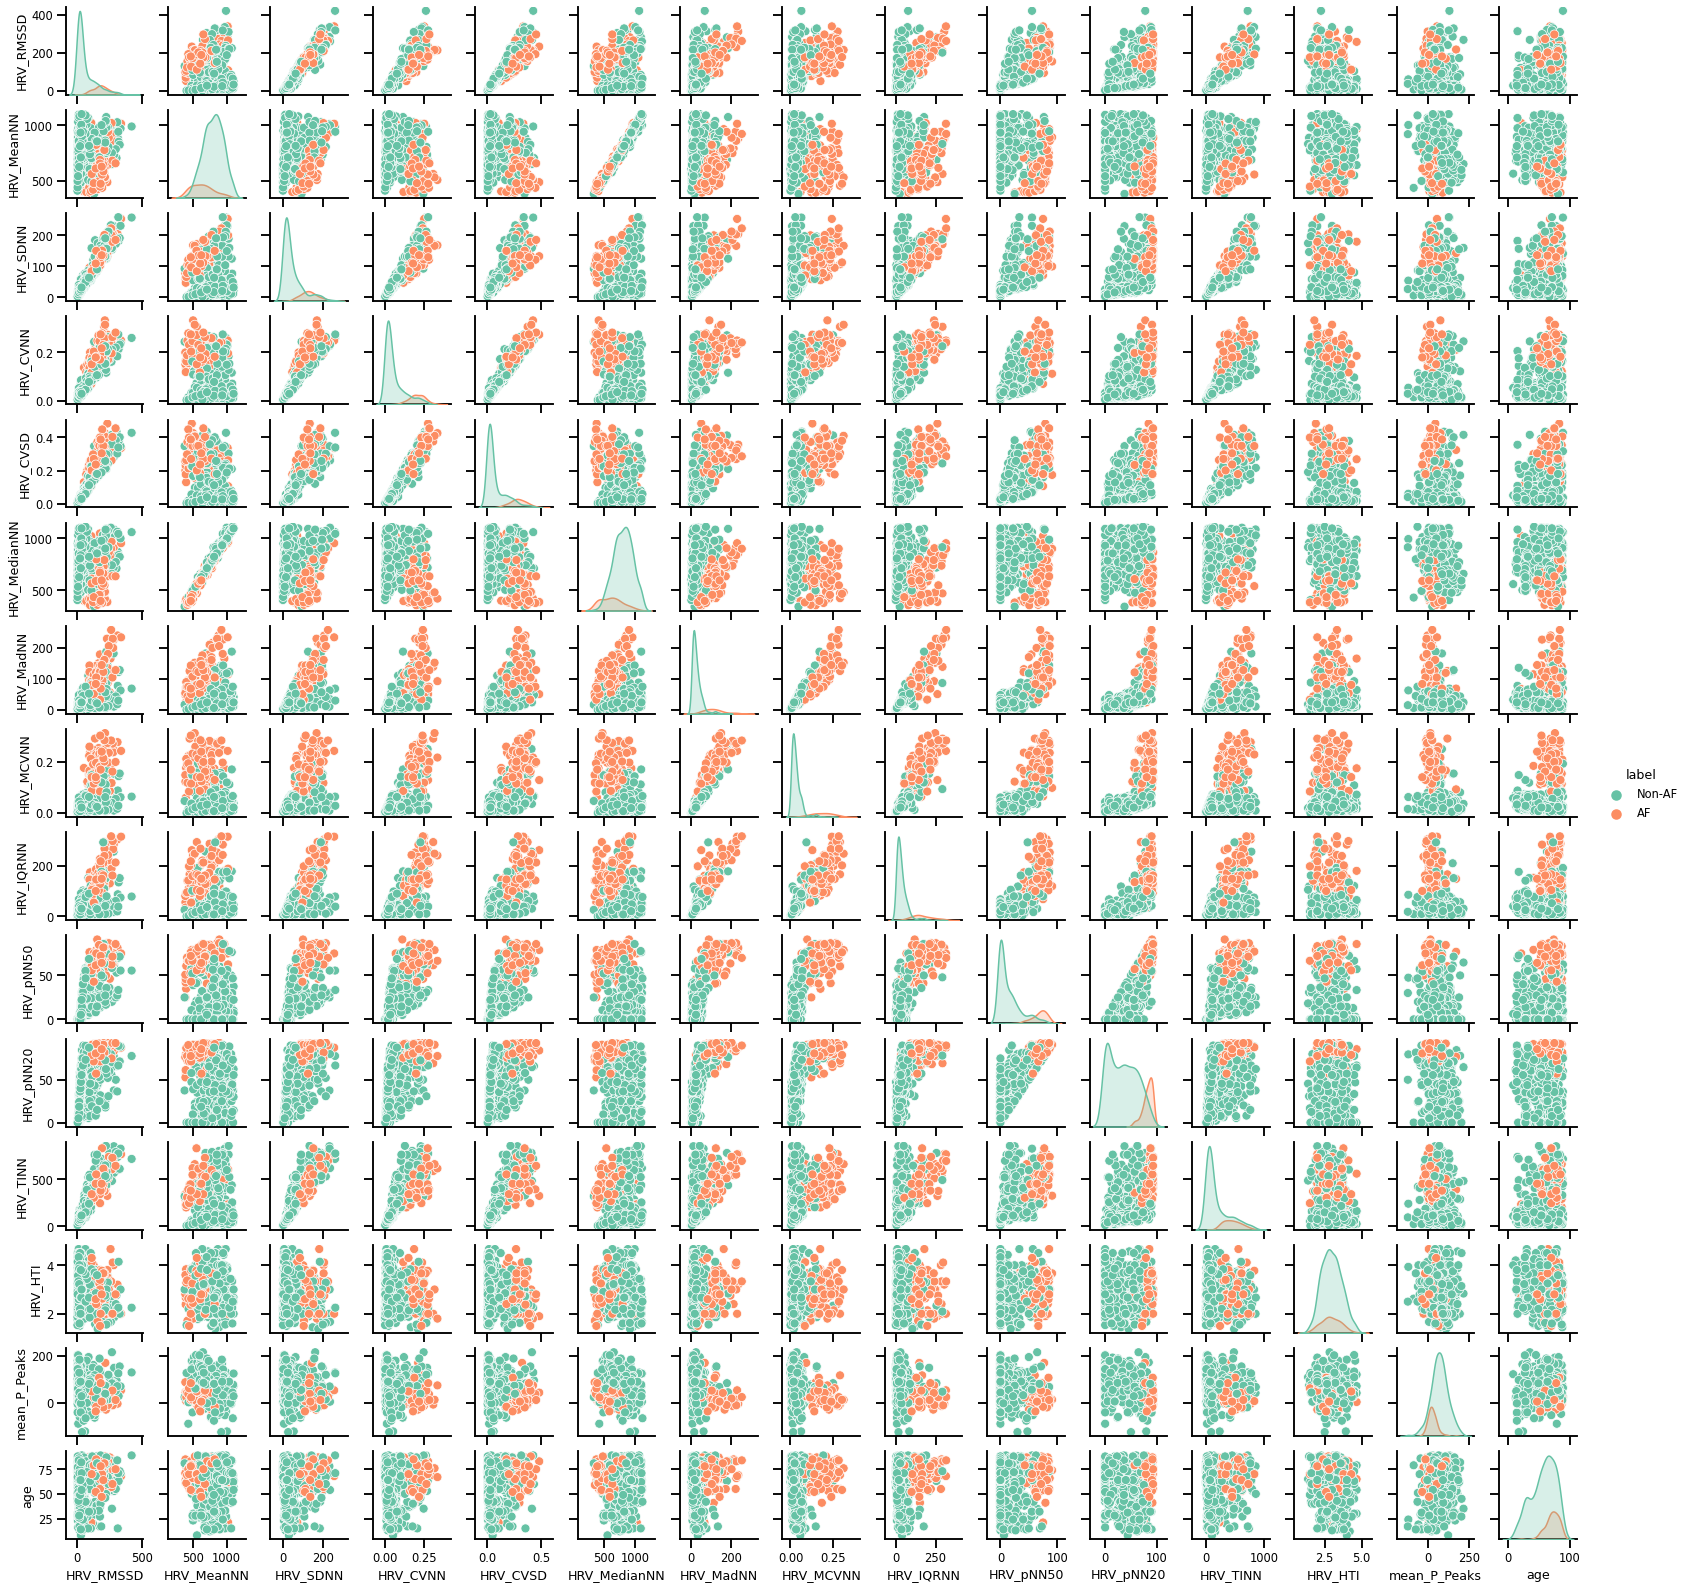

In [25]:
plt.figure(figsize=(16,17))
g = sns.pairplot(data=df.sample(frac=0.1, random_state=42), hue='label', palette='Set2', height=1.5)

g.tight_layout()
plt.show()

## We plot the Principal Component Analysis

In [22]:
scal = StandardScaler()
df_scal = scal.fit_transform(df.drop('label', axis=1))

n_comps = df_scal.shape[1]
pca = PCA(n_components = n_comps)
df_pca = pca.fit_transform(df_scal)

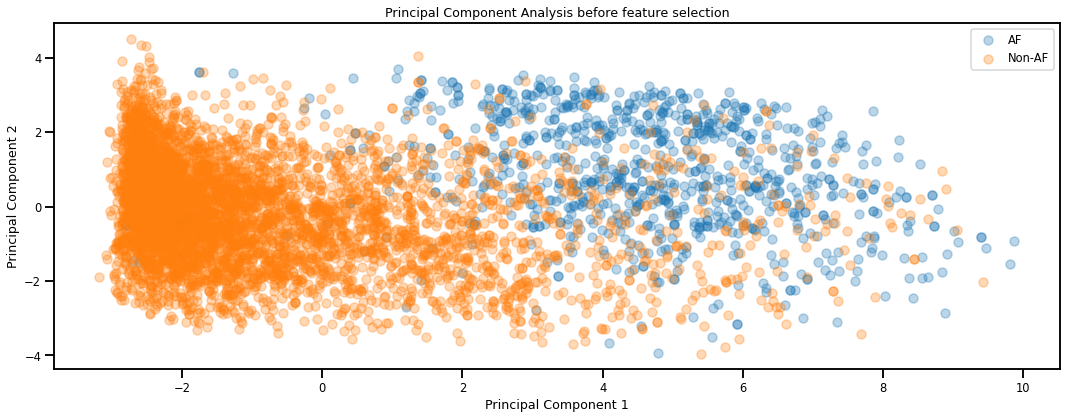

In [24]:
xpca = pd.DataFrame(df_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))

plt.scatter(xpca.loc[(df.label == 'AF').ravel(),0],xpca.loc[(df.label == 'AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(df.label == 'Non-AF').ravel(),0],xpca.loc[(df.label == 'Non-AF').ravel(),1], alpha = 0.3, label = 'Non-AF')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
ls datasets

phys-raw-lead2-HRV-corrected  phys-raw-lead2-HRV-eda


In [20]:
aux = df_raw.reset_index()
aux = aux.drop('index', axis=1)
aux.to_feather('./datasets/phys-raw-lead2-HRV-eda')

In [21]:
labels = pd.get_dummies(aux['label'])
labels.describe()

,AF,Non-AF
count,6873.000000,6873.000000
mean,0.177506,0.822494
std,0.382124,0.382124
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000
